#### Starbucks locations in washington DC

Suppose we are a supplier and we want to supply coffee beans to starbucks locations inside DC. we will use route optimization techniques to find the best possible route to visit all the store locations exactly once and go back to the original home node. this is an extension on the TSP problem

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import folium
import geopy.distance #to measure the actual distance between osmnx graph nodes and points in google maps

#for network and graph analysis
import networkx as nx
import osmnx as ox

#filter warnings
from warnings import filterwarnings
filterwarnings("ignore")

In [2]:
df = pd.read_csv('data_stores.csv')

state = 'DC'
city = 'Washington'
country = 'US'

In [3]:
df_local = df[(df['State/Province']==state) &
               (df['City'] == city) & 
               (df['Country']==country) & 
               (df['Brand'] == 'Starbucks')]\
                [['Street Address','Longitude', 'Latitude']].sample(frac=1).reset_index(drop=True)

df_local = df_local.drop_duplicates((['Longitude','Latitude']),keep='first').reset_index().rename(columns={'index':'id','Street Address':'address', 'Latitude':'y', 'Longitude':'x'})
df_local.reset_index(inplace=True)
df_local.drop(columns=['id'],inplace=True)
df_local.head()

,index,address,x,y
0,0,401 8th Street SE,-77.00,38.88
1,1,"325 Seventh Street NW, Suite 100",-77.02,38.89
2,2,775 12th St. NW,-77.03,38.90
3,3,"1825 I Street NW, Capital Gallery",-77.04,38.90
4,4,3050 K Street,-77.06,38.90


In [4]:
data = df_local.copy()

In [5]:
data.head(3)

,index,address,x,y
0,0,401 8th Street SE,-77.00,38.88
1,1,"325 Seventh Street NW, Suite 100",-77.02,38.89
2,2,775 12th St. NW,-77.03,38.90


In [6]:
data['color'] = ''
data.loc[data['index'] == 0, 'color'] = 'red'
data.loc[data['index'] != 0, 'color'] = 'black'

start = data[data['index'] == 0][['y','x']].values[0]

#print(start)
data.head(3)

,index,address,x,y,color
0,0,401 8th Street SE,-77.00,38.88,red
1,1,"325 Seventh Street NW, Suite 100",-77.02,38.89,black
2,2,775 12th St. NW,-77.03,38.90,black


In [7]:
# create a map of DC - starting from the first starbucks location
map = folium.Map(
    location= start,
    titles = 'carthodbpositron',
    zoom_start=12
)

# create indictators for starbucks stores on the map using a colored circle
data.apply( lambda row:
           folium.CircleMarker(location= [row['y'],row['x']],
                               color = row['color'],
                               fill = True,
                               radius=2.5).add_to(map),axis=1

)

map

#### Creating graphs with nodes and edges

so here  I will use open street maps networkx to create a network (graph) of all the possible routes between starbucks stores

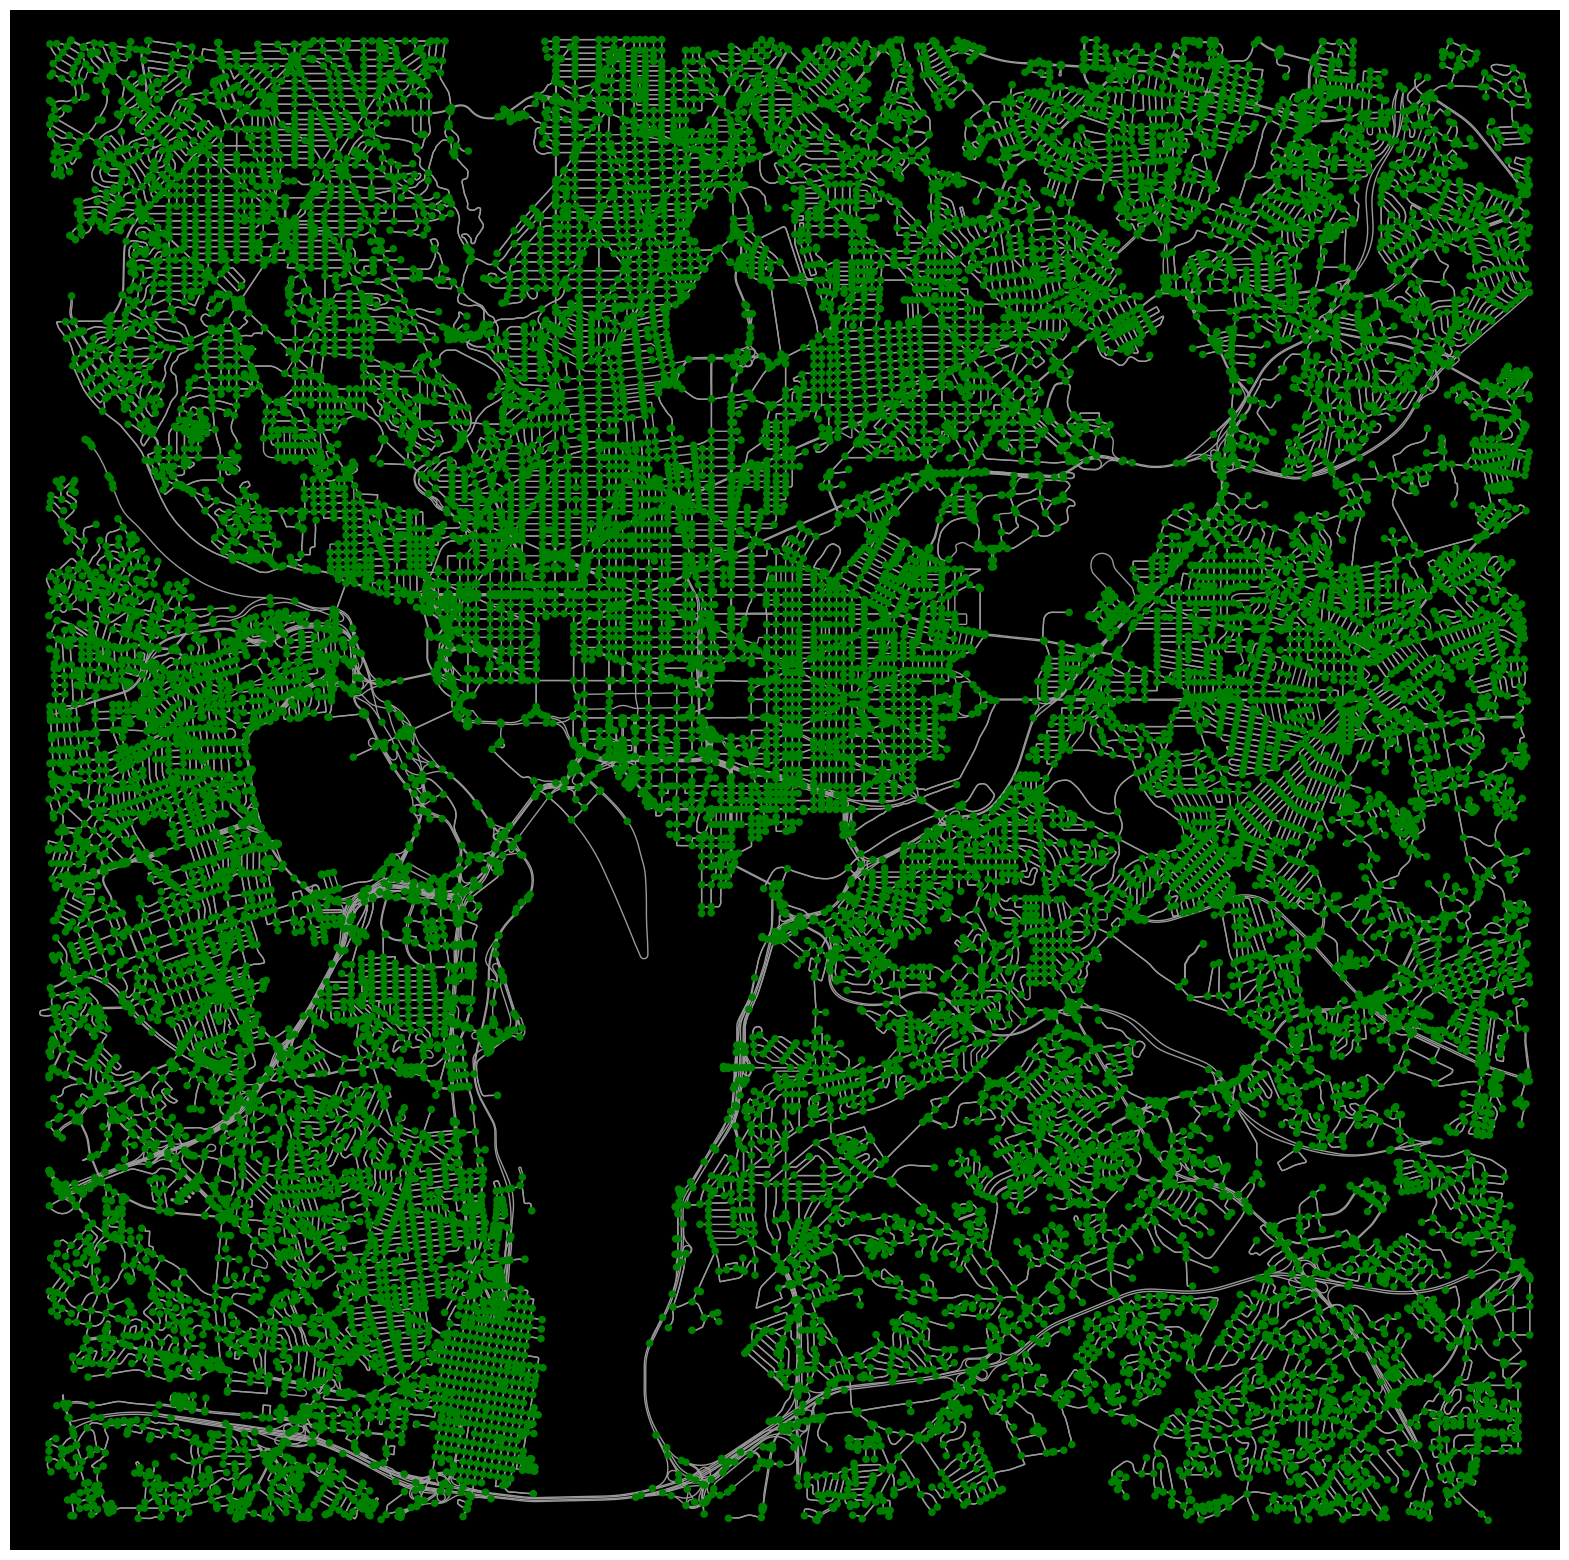

In [8]:
G = ox.graph_from_point(start, dist= 10e3, network_type='drive')
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)
G = ox.add_edge_bearings(G)

fig,ax = ox.plot_graph(G,bgcolor="black", node_size = 30, node_color = 'green', figsize = (30,20))

In [9]:
#ox.basic_stats(G)
print(len(G.edges()))

58622


In [10]:
# Convert edges to DataFrame for better viewing
edges_df = pd.DataFrame([
    {
        'source': u,
        'target': v,
        **data
    }
    for u, v, data in G.edges(data=True)
])

In [11]:
edges_df.head()

,source,target,osmid,oneway,lanes,name,highway,maxspeed,reversed,length,...,speed_kph,travel_time,bearing,ref,service,bridge,access,junction,width,tunnel
0,287905,63755704,"[999712204, 8824926]",False,2,Dawes Avenue,tertiary,25 mph,False,455.820,...,40.2,40.8,236.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,287905,3035949599,468774716,True,3,Leesburg Pike,primary,40 mph,False,210.724,...,64.4,11.8,296.1,VA 7,NaN,NaN,NaN,NaN,NaN,NaN
2,287905,623691150,"[468774721, 468774722, 468774723]",False,"[4, 5]",King Street,primary,35 mph,True,148.789,...,56.3,9.5,118.3,VA 7,NaN,NaN,NaN,NaN,NaN,NaN
3,49138097,49162951,5969017,False,NaN,Jamestown Road,residential,NaN,False,71.984,...,37.9,6.8,28.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,49138097,870406994,5969017,False,NaN,Jamestown Road,residential,NaN,True,11.742,...,37.9,1.1,204.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Now that we defined the graph object around the starting node, and we visualized the nodes and edges, we can easily find the nearest nodes to each of the store locations. lets first figure out where are the stores are located on our graph (what are the nearest nodes on graph that represents the store locations)

In [12]:
start_node = ox.distance.nearest_nodes(G,start[1],start[0])
print(start_node)
node_coords = G.nodes[start_node]
print(node_coords)
print("Node coordinates:", (node_coords['x'], node_coords['y']))
print("Original coordinates:", start)

node_point = (node_coords['y'], node_coords['x'])  # Note the swap for lat/lon
distance = geopy.distance.distance(start, node_point).meters

print(f"Distance between node and original point: {distance:.2f} meters")

642395561
{'y': 38.8799421, 'x': -76.9995484, 'ref': '1C', 'highway': 'motorway_junction', 'street_count': 3}
Node coordinates: (-76.9995484, 38.8799421)
Original coordinates: [ 38.88 -77.  ]
Distance between node and original point: 39.71 meters


Now this was for only start node - one of the store locations . lets apply the same logic for all of the other store locations in the dataframe

In [13]:
df_local["nearest_node"]=df_local[["y", "x"]].apply(lambda z: ox.distance.nearest_nodes(G, z[1], z[0]), axis=1)

In [14]:
df_local.head()

,index,address,x,y,nearest_node
0,0,401 8th Street SE,-77.00,38.88,642395561
1,1,"325 Seventh Street NW, Suite 100",-77.02,38.89,3003882945
2,2,775 12th St. NW,-77.03,38.90,3027616118
3,3,"1825 I Street NW, Capital Gallery",-77.04,38.90,49770782
4,4,3050 K Street,-77.06,38.90,2428739670


we can also check the distance for all other store locations as well. but that is not necessary*

In [15]:
def calculate_node_distance(row, graph):
    # Get the nearest node coordinates
    node_coords = graph.nodes[row['nearest_node']]
    
    # Create point tuples (note the order: latitude, longitude)
    original_point = (row['y'], row['x'])
    node_point = (node_coords['y'], node_coords['x'])
    
    # Calculate distance
    return geopy.distance.distance(original_point, node_point).meters

In [16]:
df_local['distance_to_node'] = df_local.apply(
    lambda row: calculate_node_distance(row, G), 
    axis=1
)

In [17]:
df_local.head()

,index,address,x,y,nearest_node,distance_to_node
0,0,401 8th Street SE,-77.00,38.88,642395561,39.710151
1,1,"325 Seventh Street NW, Suite 100",-77.02,38.89,3003882945,176.773151
2,2,775 12th St. NW,-77.03,38.90,3027616118,16.194735
3,3,"1825 I Street NW, Capital Gallery",-77.04,38.90,49770782,53.529283
4,4,3050 K Street,-77.06,38.90,2428739670,196.156910


In [18]:
df_local.shape

(45, 6)

now that this is out of the way, lets create the distance matrix, e.g. distance between different store locations. this will be a 45*45 matrix, where the diagonal is 0.

In [20]:
def dist(a , b):
    # this function gets two points coordinations and calculates the shortest path between them
    try:
        d=nx.shortest_path_length(G, source=a, target=b, method='dijkstra', weight='travel_time')
    except:
        d=np.nan
    return d

In [22]:
distance_matrix=np.asarray([[dist(a,b)for b in df_local["nearest_node"].tolist()] for a in df_local["nearest_node"].tolist()])
distance_matrix=pd.DataFrame(distance_matrix, columns=df_local["nearest_node"].values, index=df_local["nearest_node"].values)

In [52]:
distance_matrix= distance_matrix.round()
distance_matrix=distance_matrix.astype('int')
distance_matrix

,642395561,3003882945,3027616118,49770782,2428739670,49749265,49777795,49728175,49827112,49770672,...,2424854392,49813715,49733709,49742711,10941220963,3373614193,49825523,12292446080,650017955,293754652
642395561,0,165,257,330,411,496,217,438,489,422,...,704,796,276,730,495,810,585,849,191,528
3003882945,247,0,120,202,297,483,86,311,364,297,...,578,708,264,616,381,684,497,722,77,506
3027616118,346,123,0,91,226,582,78,200,251,185,...,466,639,294,524,277,572,427,611,100,525
49770782,413,184,67,0,158,649,142,136,191,131,...,402,656,318,457,204,508,465,547,161,572
2428739670,501,309,223,156,0,737,296,125,258,225,...,340,727,394,363,117,447,548,485,264,639
49749265,317,481,574,647,728,0,533,755,806,739,...,1021,1113,592,1047,812,1127,901,1165,508,844
49777795,286,88,75,159,287,522,0,241,292,225,...,507,629,348,585,328,613,417,651,140,594
49728175,500,300,184,125,109,736,237,0,133,102,...,273,602,443,413,87,379,423,417,278,689
49827112,552,356,244,194,256,788,290,147,0,114,...,303,482,513,537,220,439,302,458,337,749
49770672,438,242,130,99,198,674,176,92,123,0,...,358,578,404,496,179,464,398,502,224,635


In [53]:
distance_matrix.shape

(45, 45)

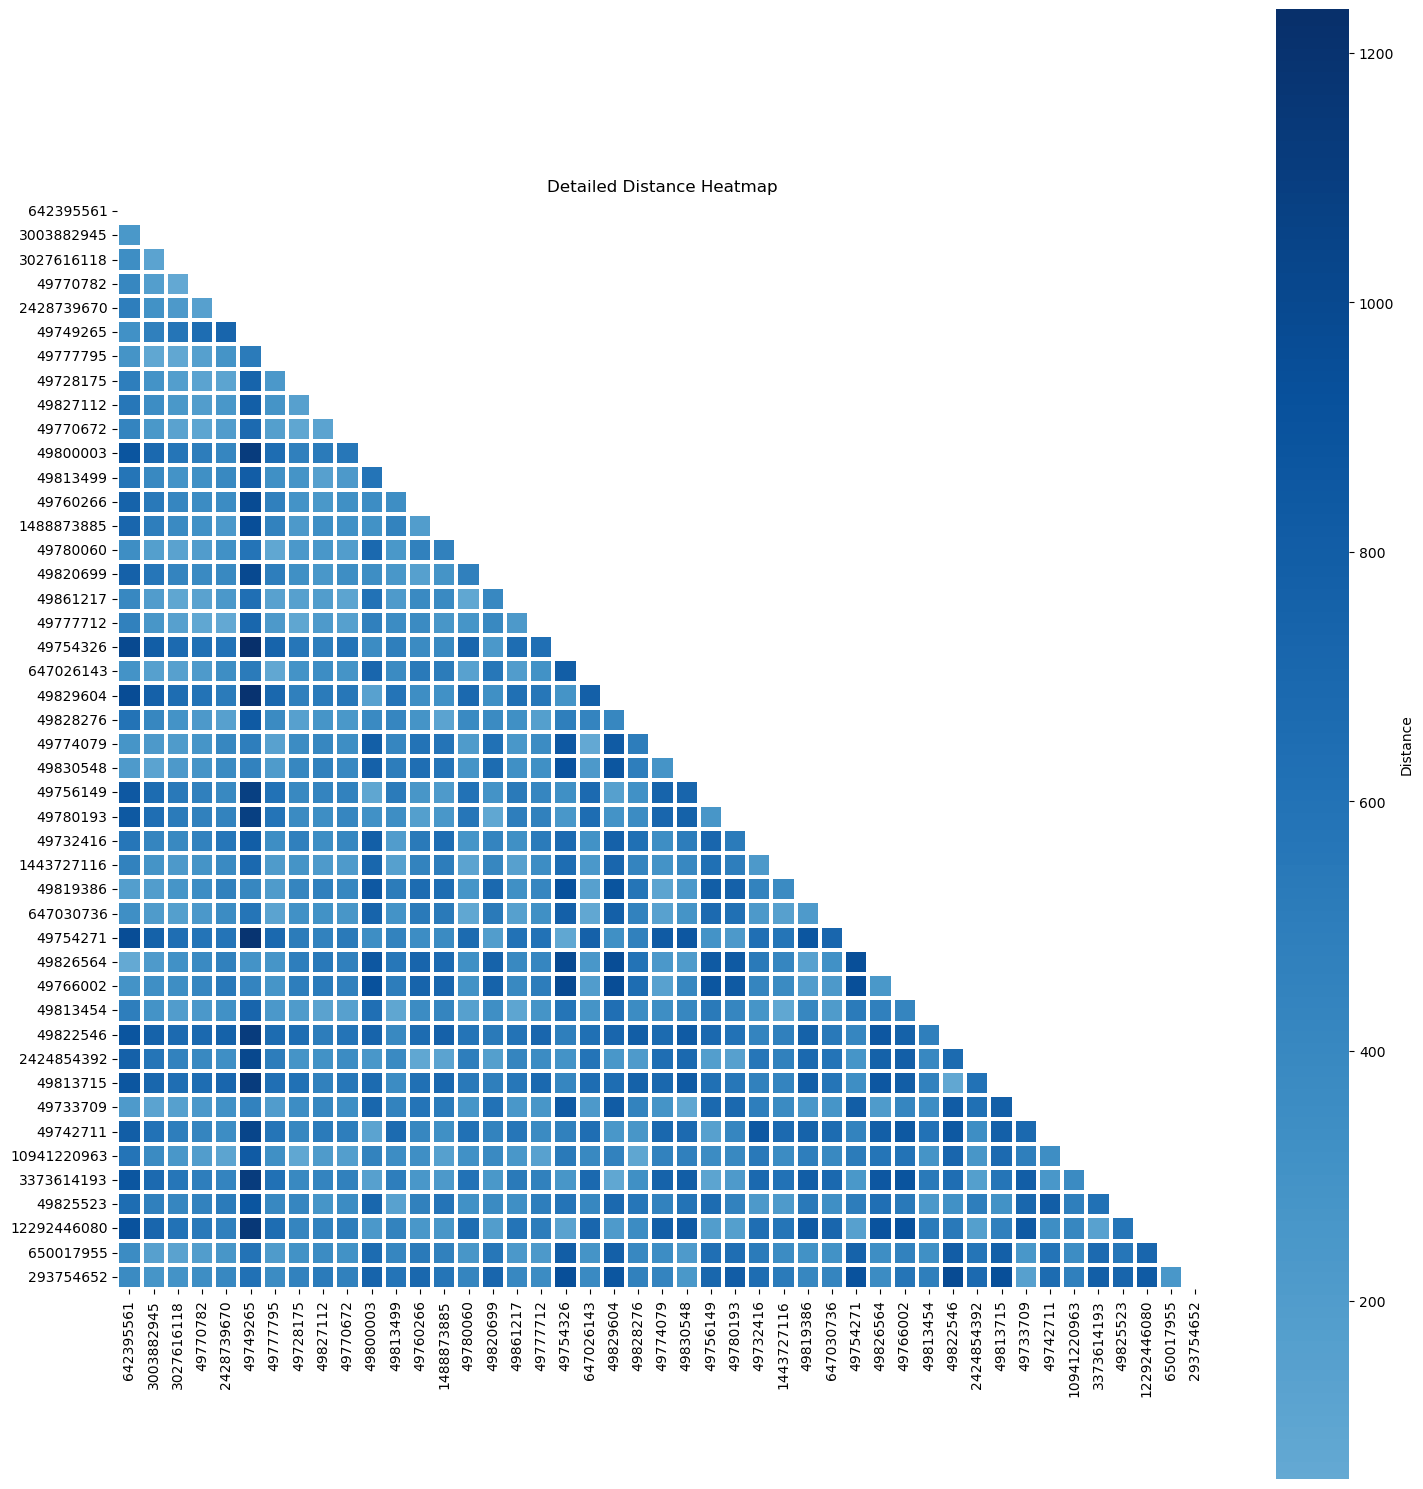

In [58]:
# Optional: Mask to hide redundant half of symmetric matrix
mask = np.triu(np.ones_like(distance_matrix, dtype=bool))

plt.figure(figsize=(15,15))
sns.heatmap(distance_matrix, 
            mask=mask,             # Masks upper triangle 
            cmap='Blues',       # Alternative color scheme
            center=0,              # Centers color scheme
            annot=False,           # Can set to True to show values
            cbar_kws={'label': 'Distance'},
            square=True,           # Makes cells square
            linewidths=1.5,        # Adds grid lines
            #fmt=".2f"              # Format of annotations if shown
            )             

plt.title('Detailed Distance Heatmap')
plt.tight_layout()
plt.show()